## A/B Testing 

There are two site_version in the given data - mobile and desktop. 
In this notebook we are trying to figure out on which site_version is better in yielding better results.

### Choosing the Success Metric
In this case the metric of choice is the 'target'. 'target' as 1 means sales conversion while 0 means no sales.

### Other 

Practical significance is the minimum change to the baseline rate that is useful to the business, for example an increase in the conversion rate of 0.001% may not be worth the effort required to make the change whereas a 2% change is potential enough to go for the change. The value in this case is defined as 1%

Confidence level also called significance level is the probability that the null hypothesis is rejected when it shouldn’t be rejected. The value in this case is defined as 5%


### Hypothesis :
I’ll test the null hypothesis that the probability of target conversion in the mobile group minus the probability of target conversion in the desktop group equals zero. And set the alternative hypothesis to be that the probability of conversion in the mobile group minus the probability of conversion in the desktop group does not equal zero. The significance level for the experiment is 5%, however the practical significance is 1%



### About the Data

The data has the following columns. The data dictionary has been assumed as the following :

1. order_id - unique purchase number (NA for banner clicks and impressions)
2. user_id - unique identifier of the client
3. page_id - unique page number for event (NA for purchases)
4. product - banner / purchase product
5. site_version - version of the site (mobile or desktop)
6. time - time of the action
7. title - type of event (show, click or purchase)
8. target - target class - 1 or 0


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/how-to-do-product-analytics/product.csv


In [3]:
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [4]:
df = pd.read_csv('/kaggle/input/how-to-do-product-analytics/product.csv', sep=',')
df.shape

(8471220, 8)

In [5]:
df.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,2019-01-11 09:24:43,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,2019-01-09 09:38:51,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,2019-01-09 09:12:45,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:58:18,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,2019-01-03 08:59:15,banner_click,0


In [6]:
# finding the number of unique values in each column :

df.nunique()

order_id        8471220
user_id         4254619
page_id         7393316
product               5
site_version          2
time            5799549
title                 3
target                2
dtype: int64

Order distribution by site_version 
               order_id
site_version          
desktop        2382885
mobile         6088335

Conversion rate by site_version 
 site_version
desktop    0.055891
mobile     0.018977
Name: target, dtype: float64


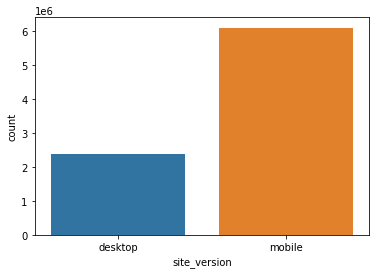

In [7]:
# checking the distribution of orders based on site_version
print('Order distribution by site_version \n',df.groupby('site_version')[['order_id']].count())
# checking for the distribution of target in terms of site_version
print('\nConversion rate by site_version \n', df.groupby('site_version').target.mean())

sns.countplot('site_version', data = df)

Order distribution by title 
               page_id
title                
banner_click   829184
banner_show   7393314
order          248722


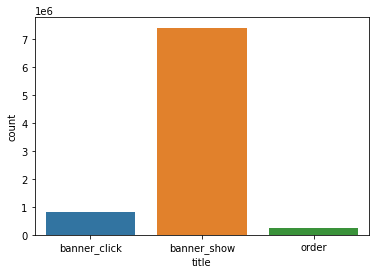

In [8]:
# checking the distribution of orders based on title
print('Order distribution by title \n',df.groupby('title')[['page_id']].count())

sns.countplot('title', data = df)


In [9]:
# checking the distribution of orders based on products
print('Order distribution by product \n',df.groupby('product')[['order_id']].count())

# checking the target conversion of orders based on products
print('\nOrder distribution by product \n',df.groupby('product').target.mean())

Order distribution by product 
                   order_id
product                   
accessories        1621759
clothes            1786438
company            1725056
sneakers           1703342
sports_nutrition   1634625

Order distribution by product 
 product
accessories         0.027471
clothes             0.063095
company             0.000000
sneakers            0.039757
sports_nutrition    0.014521
Name: target, dtype: float64


Based on the above we see that company doesnt have any target as 1. 
Assumption can be that this data is redundant or may be its a banner just for branding and doesnt have any CTA for target conversion. So, it makes sense to drop the values of this product type

In [10]:
df = df[df['product'] != 'company']

Time wise classification of the records


In [11]:
#strip the date and make a time series chart
df['date'] = pd.to_datetime(df['time']).dt.date
time_data = df.groupby(['date','site_version']).agg({'target':'sum'}).reset_index()

In [12]:
time_data.head()

,date,site_version,target
0,2019-01-01,desktop,410
1,2019-01-01,mobile,368
2,2019-01-02,desktop,408
3,2019-01-02,mobile,342
4,2019-01-03,desktop,376


In [13]:
time_data
# Create dummy variables for 2 columns
time_data_site_version = pd.get_dummies(time_data['site_version'])
#df_Churn = pd.get_dummies(df[‘Churn’])
#Concat new columns to original dataframe 
df_concat = pd.concat([time_data, time_data_site_version], axis=1)
print (df_concat.head())
df_concat.drop(['site_version'], inplace=True, axis=1)
print (df_concat.head())

         date site_version  target  desktop  mobile
0  2019-01-01      desktop     410        1       0
1  2019-01-01       mobile     368        0       1
2  2019-01-02      desktop     408        1       0
3  2019-01-02       mobile     342        0       1
4  2019-01-03      desktop     376        1       0
         date  target  desktop  mobile
0  2019-01-01     410        1       0
1  2019-01-01     368        0       1
2  2019-01-02     408        1       0
3  2019-01-02     342        0       1
4  2019-01-03     376        1       0


The treatment group is the mobile site_version group while the control group is the desktop site_version control group


In [15]:
#Show the % split between users who saw new vs old page
#Calculate pooled probability
mask = (df["site_version"] == "desktop")
conversions_control = df["target"][mask].sum()
total_users_control = df["target"][mask].count()

mask = (df["site_version"] == "mobile")
conversions_treatment = df["target"][mask].sum()
total_users_treatment = df["target"][mask].count()

print("Split of control users who saw on desktop vs users who saw on mobile: ", 
          round(total_users_control / df["target"].count() * 100, 2), "% ",
          round((total_users_treatment / df["target"].count()) * 100, 2), "%")

#count number of users who converted in each group
print("Number of control users who converted on desktop: ", conversions_control)
print("Percentage of control users who converted: ", round((conversions_control / total_users_control) * 100, 2), "%")

mask = (df["site_version"] == "mobile")
print("Number of treatment users who converted on new page: ", conversions_treatment)
print("Percentage of treatment users who converted: ", round((conversions_treatment/ total_users_treatment) * 100, 2), "%")

Split of control users who saw on desktop vs users who saw on mobile:  27.82 %  72.18 %
Number of control users who converted on desktop:  133181
Percentage of control users who converted:  7.1 %
Number of treatment users who converted on new page:  115541
Percentage of treatment users who converted:  2.37 %


Set Test Parameters

In [16]:
import statsmodels.stats.api as sms
import scipy.stats as st

#Check what sample size is required
baseline_rate = conversions_control / total_users_control
practical_significance = 0.01 #user defined
confidence_level = 0.05 #user defined, for a 95% confidence interval
sensitivity = 0.8 #user defined

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  11006  per group


## A/B Test

In [17]:

#Calculate pooled probability
mask = (df["site_version"] == "desktop")
conversions_control = df["target"][mask].sum()
total_users_control = df["target"][mask].count()

mask = (df["site_version"] == "mobile")
conversions_treatment = df["target"][mask].sum()
total_users_treatment = df["target"][mask].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

print("Pooled Probability : ", prob_pooled)

Pooled Probability :  0.036868656024371775


In [18]:
import math

#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")

Do not reject the null hypothesis
The lower bound of the confidence interval is  -4.75 %
The upper bound of the confidence interval is  -4.69 %
